# 比較 bag of words 和 tf-idf 裡的詞彙(words)

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from enum import Enum
from pprint import pprint
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

## 自定義 data types and functions

In [2]:
class ContentType(Enum):
    TIT = 'title'
    ABS = 'abstract'
    AUT = 'author'
    SEC = 'section'
    
def get_contents(content_type):
    all_contents = []
    dataset_path = '../dataset'
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            with open(file_path) as f:  
                line = f.readlines()
                if content_type == ContentType.AUT:
                    line = line[1]
                elif content_type == ContentType.SEC:
                    line = line[2]
                elif content_type == ContentType.ABS:
                    line = line[3]
                else:
                    line = line[0]
                line = line.strip()
                all_contents.append(line)
        else:
            print(file_path + ' does not exist.')
    return all_contents


def get_all_titles():
    return get_contents(ContentType.TIT)

def get_all_authors():        
    return get_contents(ContentType.AUT)

def get_all_sections():
    return get_contents(ContentType.SEC)

def get_all_abstracts():
    return get_contents(ContentType.ABS)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            token = wordnet_lemmatizer.lemmatize(token, pos='v')
            token = wordnet_lemmatizer.lemmatize(token, pos='n')
            result.append(token)
    return result

def show_chart(num_topics,num_words,topics):
    K = num_topics
    topicWordProbMat = topics
    
    #columns = ['1','2','3','4','5']
    columns = range(1,num_topics+1)

    df = pd.DataFrame(columns = columns)
    pd.set_option('display.width', 1000)

    # 40 will be resized later to match number of words in DC
    zz = np.zeros(shape=(80,K))

    last_number = 0
    DC = {}

    for x in range (num_words): #取每個topic前10個字
        data= pd.DataFrame(columns=columns,index=[0])
        for i in range(num_topics):
            data[columns[i]] = ""
        df = df.append(data,ignore_index=True)  

    for line in topicWordProbMat:
        topic_id,words = line #一個line是一個topic
        probs = words.split("+")
        y = 0 #用來算第幾個word
        for pr in probs:    
            a = pr.split("*")
            df.iloc[y,topic_id] = a[1] #該word

            if a[1] in DC:
                zz[DC[a[1]]][topic_id] = a[0] #該word的機率
            else:
                zz[last_number][topic_id] = a[0]
                DC[a[1]] = last_number
                last_number = last_number+1
            y = y + 1

    show_words_table(df)
    show_dictionary(DC)
    show_probs_table(zz)
    show_heapmap(DC,zz)

def show_words_table(df):  
    print(df)
    print('\n')
    
def show_dictionary(DC):
    print(DC)
    print('字典字數：',len(DC))
    print('\n')

def show_probs_table(zz):
    print(zz)
    print(zz.shape)
    
def show_heapmap(DC,zz):
    %matplotlib inline

    zz = np.resize(zz,(len(DC.keys()),zz.shape[1]))

    for val, key in enumerate(DC.keys()):
            plt.text(-3.5, val + 0.1, key,
                     horizontalalignment='right',
                     verticalalignment='center'
                     )

    #plt.figure(figsize=(10,50))
    plt.imshow(zz, cmap='hot', interpolation='nearest',aspect='auto')
    plt.show()

### 取出所有摘要

In [15]:
contents = get_all_abstracts()
print('共',len(contents),'篇論文\n')

documents = pd.DataFrame(data=contents,columns=['abstract'])
documents['index'] = documents.index
documents[:10]

contents[137]

共 1343 篇論文



'The task of entity alignment between knowledge graphs aims to find entities in two knowledge graphs that represent the same real-world entity. Recently, embedding-based models are proposed for this task. Such models are built on top of a knowledge graph embedding model that learns entity embeddings to capture the semantic similarity between entities in the same knowledge graph. We propose to learn embeddings that can capture the similarity between entities in different knowledge graphs. Our proposed model helps align entities from different knowledge graphs, and hence enables the integration of multiple knowledge graphs. Our model exploits large numbers of attribute triples existing in the knowledge graphs and generates attribute character embeddings. The attribute character embedding shifts the entity embeddings from two knowledge graphs into the same space by computing the similarity between entities based on their attributes. We use a transitivity rule to further enrich the number 

### 預處理的全部論文摘要

In [4]:
processed_docs = documents['abstract'].map(preprocess)
processed_docs[:10]

0    [consider, problem, actively, elicit, preferen...
1    [investigate, task, distractor, generation, mu...
2    [common, representation, formalism, plan, desc...
3    [statistical, relational, learn, model, powerf...
4    [multimodal, representation, learn, gain, deep...
5    [reinforcement, learn, show, advantage, image,...
6    [select, appropriate, tutor, help, action, acc...
7    [recognize, time, expression, fundamental, imp...
8    [face, large, scale, image, datasets, online, ...
9    [temporal, model, video, fundamental, challeng...
Name: abstract, dtype: object

### 取其中一篇論文作為sample document

In [5]:
titles = get_all_titles()
titles.index('Entity Alignment between Knowledge Graphs Using Attribute Embeddings')

137

In [6]:
sample_doc_id = 137

## Dataset

### 產生字典

In [7]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print('共',len(dictionary),'個字\n')

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#dic1 = []
#for v in dictionary.itervalues():
#    dic1.append(v)

共 6927 個字

0 active
1 actively
2 adaptive
3 aggregation
4 algorithm
5 allow
6 approach
7 bind
8 coefficient
9 collective
10 combinatorial


# 濾掉字典 (出現不低於10篇的字，或是，出現不高於0.2個語料庫的字)

In [8]:
#dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=100000)
#print('共',len(dictionary),'個字\n')

#dic2 = []
#for v in dictionary.itervalues():
#    dic2.append(v)

#list(set(dic1) - set(dic2))

### 產生 bag of words corpus

In [9]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print('共',len(bow_corpus),'筆')

共 1343 筆


### 查看 sample document 的 bow

In [10]:
c = 0
sample_doc_bow = bow_corpus[sample_doc_id]
for i in range(len(sample_doc_bow)):
    #print("Word {} (\"{}\") appears {} time.".format(sample_doc_bow[i][0], 
    #                                           dictionary[sample_doc_bow[i][0]],
    #                                                 sample_doc_bow[i][1]))
    c = c + sample_doc_bow[i][1]
    
print('不重複共',len(sample_doc_bow),'字')
print('共',c,'字')

不重複共 48 字
共 110 字


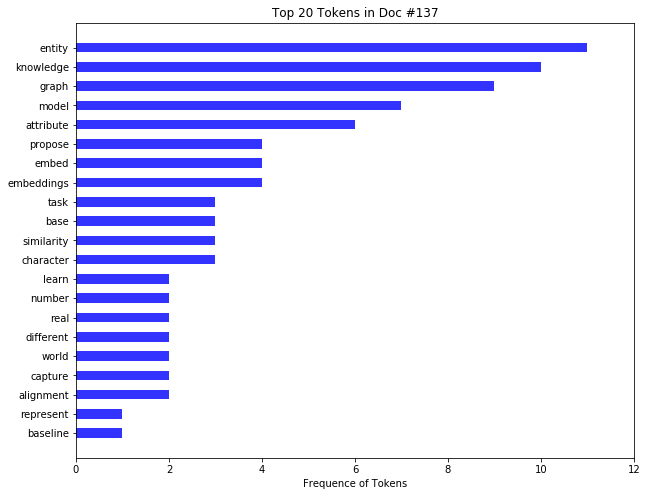

In [11]:
sample_doc_bow = bow_corpus[sample_doc_id]
sorted_doc_bow = sorted(sample_doc_bow, key=lambda l:l[1], reverse=True)

count = 0
w = []
f = []
for d in sorted_doc_bow:
    w.append(dictionary[d[0]])
    f.append(d[1])
    count += 1
    if count > 20:
        break

%matplotlib inline
plt.figure(figsize=(10,8))

plt.barh(range(len(w)), f, 0.5, color='b', alpha = 0.8)
plt.title('Top 20 Tokens in Doc #137')
plt.xlabel('Frequence of Tokens')
plt.yticks(range(len(w)), w)
plt.xlim([0,12])
plt.gca().invert_yaxis()
plt.show()

### 產生 TF-IDF Corpus

In [12]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### 查看 sample document 的 tf-idf

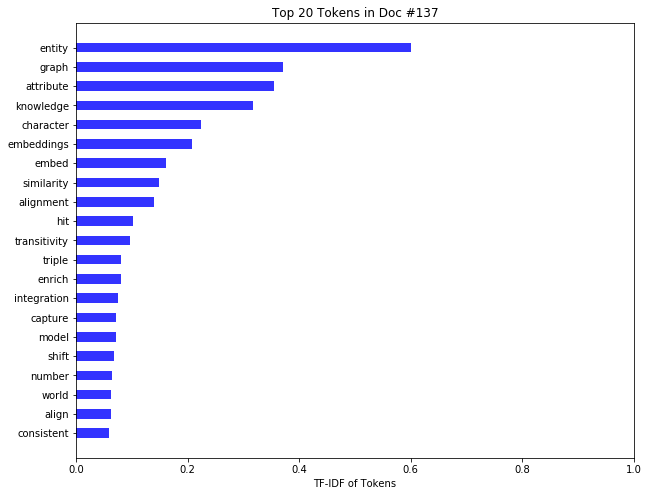

In [13]:
# sample doc的tf-idf
sample_doc_tfidf = corpus_tfidf[sample_doc_id]
sorted_doc_tfidf = sorted(sample_doc_tfidf, key=lambda l:l[1], reverse=True)

count = 0
w = []
f = []
for d in sorted_doc_tfidf:
    w.append(dictionary[d[0]])
    f.append(d[1])
    count += 1
    if count > 20:
        break
    
%matplotlib inline
plt.figure(figsize=(10,8))
plt.barh(range(len(w)), f, 0.5, color='b', alpha = 0.8)
plt.title('Top 20 Tokens in Doc #137')
plt.xlabel('TF-IDF of Tokens')
plt.yticks(range(len(w)),w)
plt.xlim([0,1])
plt.gca().invert_yaxis()
plt.show()

In [14]:
topn = 20

sample_doc_bow = bow_corpus[sample_doc_id]
sample_doc_tfidf = corpus_tfidf[sample_doc_id]

sorted_doc_bow = sorted(sample_doc_bow, key=lambda l:l[1], reverse=True)
sorted_doc_tfidf = sorted(sample_doc_tfidf, key=lambda l:l[1], reverse=True)

count = 0
w1 = []
w2 = []
for i in range(len(sorted_doc_bow)):
    w1.append(dictionary[sorted_doc_bow[i][0]])
    w2.append(dictionary[sorted_doc_tfidf[i][0]])
    count += 1
    if count > topn:
        break
        
compare_mat = pd.DataFrame({'BOW':w1,'TFIDF':w2})
compare_mat

,BOW,TFIDF
0,entity,entity
1,knowledge,graph
2,graph,attribute
3,model,knowledge
4,attribute,character
5,propose,embeddings
6,embed,embed
7,embeddings,similarity
8,task,alignment
9,base,hit
